<a href="https://colab.research.google.com/github/nyjinnn/images/blob/main/%5B220717_%EC%88%99%EC%A0%9Cver.1%5Dweek8_quiz_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np 

In [13]:

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


In [14]:
class_names = ["0", "1", "2", "3", "4", "5", "6","7","8","9"]

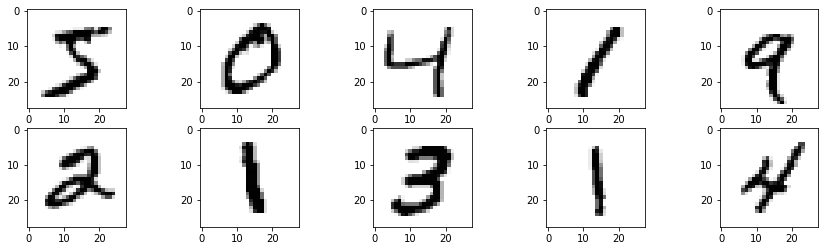

In [15]:
fig = plt.figure(figsize=(15, 4))

for i in range(10):
    plottable_image = np.reshape(x_train[i], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')

In [17]:
from sklearn.model_selection import train_test_split 
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [18]:
print("학습 데이터셋 클래스별 샘플 수 : ", np.bincount(y_train))
print("평가 데이터셋 클래스별 샘플 수 : ", np.bincount(y_valid))

학습 데이터셋 클래스별 샘플 수 :  [4738 5394 4766 4905 4674 4337 4734 5012 4681 4759]
평가 데이터셋 클래스별 샘플 수 :  [1185 1348 1192 1226 1168 1084 1184 1253 1170 1190]


In [19]:
x_train = x_train / 255
x_valid = x_valid / 255 
x_test = x_test / 255 

In [20]:
x_train_reshape = x_train.reshape(-1, 784) 
x_valid_reshape = x_valid.reshape(-1, 784)
x_test_reshape = x_test.reshape(-1, 784)

print("학습 데이터 셋의 형태 : ", x_train_reshape.shape)
print("검증 데이터 셋의 형태 : ", x_valid_reshape.shape)

학습 데이터 셋의 형태 :  (48000, 784)
검증 데이터 셋의 형태 :  (12000, 784)


In [53]:
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [54]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_valid_encoded = tf.keras.utils.to_categorical(y_valid)

In [55]:
print(y_train[0], y_train_encoded[0], class_names[y_train[0]])


1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1


In [56]:
import torch
x_train_torch = torch.FloatTensor(x_train_reshape)
y_train_torch = torch.FloatTensor(y_train_encoded)
x_valid_torch = torch.FloatTensor(x_valid_reshape)
y_valid_torch = torch.FloatTensor(y_valid_encoded) 
x_test_torch = torch.FloatTensor(x_test_reshape)
y_test_torch = torch.FloatTensor(y_test)

In [71]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [72]:
class numberDataset(Dataset):
  def __init__(self, x, y):
    self.x_data = x
    self.y_data = y
  
  def __getitem__(self, index):
    x = self.x_data[index]
    y = self.y_data[index]
    return x, y
  
  def collate_fn(self, batch):
    x, y = zip(*batch) #batch 사이즈만큼 커짐
    return x, y

  def __len__(self):
    return len(self.x_data)

In [73]:
dataset = numberDataset(x_train_torch, y_train_torch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

In [78]:
for b in dataloader:
    x_batch=b[0]
    y_batch=b[1]
    print("배치사이즈:", len(x_batch))
    print("데이터 크기:", (x_batch.size()))
    print("타겟 크기:", (y_batch.size()))
    break

배치사이즈: 32
데이터 크기: torch.Size([32, 784])
타겟 크기: torch.Size([32, 10])


In [93]:
from tqdm import tqdm 
import random 

random_seed = 220805
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

model = nn.Sequential(
    nn.Linear(784, 700),
    nn.ReLU(), 
    nn.Linear(700, 600),
    nn.ReLU(), 
    nn.Linear(600, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(), 
    nn.Linear(200, 10),
    nn.Softmax()
    )

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()



global_step = 0 
for epoch in range(25):
  t = tqdm(dataloader, ncols=100)
  for i, batch in enumerate(t):
    x_batch = batch[0]
    y_batch = batch[1]
    output = model(x_batch)
    loss = criterion(output, y_batch)
    model.zero_grad() 
    optim.zero_grad()
    loss.backward() #gradiant(기울기)구하고
    optim.step()    #적용(업데이트)

    global_step += 1
    t.set_description("epoch: {} | global_step: {:8d} | loss: {:.4f}".format(epoch + 1, global_step, loss))
  predicts = model(x_valid_torch)
  predicts = torch.argmax(predicts, 1)

  correct = 0 
  for i in range(len(predicts)):
    if predicts[i].item() == y_valid[i]: #torch에서 scalar(값) 가져오는 것 (item함수)
      correct += 1
  acc = correct / len(predicts)
  print("epoch: {} | global_step: {} | valid acc: {:%}".format(epoch + 1, global_step, acc))

  0%|                                                                      | 0/1500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
epoch: 1 | global_step:     1500 | loss: 1.6032: 100%|██████████| 1500/1500 [00:32<00:00, 45.53it/s]


epoch: 1 | global_step: 1500 | valid acc: 90.583333%


epoch: 2 | global_step:     3000 | loss: 1.5611: 100%|██████████| 1500/1500 [00:32<00:00, 45.76it/s]


epoch: 2 | global_step: 3000 | valid acc: 92.258333%


epoch: 3 | global_step:     4500 | loss: 1.5033: 100%|██████████| 1500/1500 [00:33<00:00, 45.41it/s]


epoch: 3 | global_step: 4500 | valid acc: 94.633333%


epoch: 4 | global_step:     6000 | loss: 1.4614: 100%|██████████| 1500/1500 [00:33<00:00, 45.04it/s]


epoch: 4 | global_step: 6000 | valid acc: 95.275000%


epoch: 5 | global_step:     7500 | loss: 1.4931: 100%|██████████| 1500/1500 [00:32<00:00, 45.80it/s]


epoch: 5 | global_step: 7500 | valid acc: 95.533333%


epoch: 6 | global_step:     9000 | loss: 1.4769: 100%|██████████| 1500/1500 [00:33<00:00, 45.39it/s]


epoch: 6 | global_step: 9000 | valid acc: 96.191667%


epoch: 7 | global_step:    10500 | loss: 1.4925: 100%|██████████| 1500/1500 [00:32<00:00, 45.56it/s]


epoch: 7 | global_step: 10500 | valid acc: 96.300000%


epoch: 8 | global_step:    12000 | loss: 1.4919: 100%|██████████| 1500/1500 [00:34<00:00, 43.69it/s]


epoch: 8 | global_step: 12000 | valid acc: 96.266667%


epoch: 9 | global_step:    13500 | loss: 1.4941: 100%|██████████| 1500/1500 [00:33<00:00, 44.69it/s]


epoch: 9 | global_step: 13500 | valid acc: 96.783333%


epoch: 10 | global_step:    15000 | loss: 1.4924: 100%|█████████| 1500/1500 [00:33<00:00, 45.04it/s]


epoch: 10 | global_step: 15000 | valid acc: 97.000000%


epoch: 11 | global_step:    16500 | loss: 1.4899: 100%|█████████| 1500/1500 [00:34<00:00, 44.03it/s]


epoch: 11 | global_step: 16500 | valid acc: 96.700000%


epoch: 12 | global_step:    18000 | loss: 1.5220: 100%|█████████| 1500/1500 [00:33<00:00, 45.06it/s]


epoch: 12 | global_step: 18000 | valid acc: 96.725000%


epoch: 13 | global_step:    19500 | loss: 1.4612: 100%|█████████| 1500/1500 [00:33<00:00, 45.10it/s]


epoch: 13 | global_step: 19500 | valid acc: 97.083333%


epoch: 14 | global_step:    21000 | loss: 1.4612: 100%|█████████| 1500/1500 [00:32<00:00, 45.93it/s]


epoch: 14 | global_step: 21000 | valid acc: 97.341667%


epoch: 15 | global_step:    22500 | loss: 1.5236: 100%|█████████| 1500/1500 [00:33<00:00, 44.55it/s]


epoch: 15 | global_step: 22500 | valid acc: 97.308333%


epoch: 16 | global_step:    24000 | loss: 1.4970: 100%|█████████| 1500/1500 [00:33<00:00, 45.31it/s]


epoch: 16 | global_step: 24000 | valid acc: 96.950000%


epoch: 17 | global_step:    25500 | loss: 1.4648: 100%|█████████| 1500/1500 [00:33<00:00, 45.42it/s]


epoch: 17 | global_step: 25500 | valid acc: 97.350000%


epoch: 18 | global_step:    27000 | loss: 1.4613: 100%|█████████| 1500/1500 [00:32<00:00, 45.48it/s]


epoch: 18 | global_step: 27000 | valid acc: 97.091667%


epoch: 19 | global_step:    28500 | loss: 1.4911: 100%|█████████| 1500/1500 [00:33<00:00, 44.94it/s]


epoch: 19 | global_step: 28500 | valid acc: 97.166667%


epoch: 20 | global_step:    30000 | loss: 1.5238: 100%|█████████| 1500/1500 [00:33<00:00, 45.33it/s]


epoch: 20 | global_step: 30000 | valid acc: 97.541667%


epoch: 21 | global_step:    31500 | loss: 1.4612: 100%|█████████| 1500/1500 [00:33<00:00, 44.99it/s]


epoch: 21 | global_step: 31500 | valid acc: 97.483333%


epoch: 22 | global_step:    33000 | loss: 1.4612: 100%|█████████| 1500/1500 [00:33<00:00, 44.97it/s]


epoch: 22 | global_step: 33000 | valid acc: 97.450000%


epoch: 23 | global_step:    34500 | loss: 1.4612: 100%|█████████| 1500/1500 [00:34<00:00, 43.62it/s]


epoch: 23 | global_step: 34500 | valid acc: 97.208333%


epoch: 24 | global_step:    36000 | loss: 1.4612: 100%|█████████| 1500/1500 [00:33<00:00, 44.85it/s]


epoch: 24 | global_step: 36000 | valid acc: 97.458333%


epoch: 25 | global_step:    37500 | loss: 1.4612: 100%|█████████| 1500/1500 [00:33<00:00, 44.60it/s]


epoch: 25 | global_step: 37500 | valid acc: 97.666667%


In [94]:
predict = model(x_test_torch)
predict = torch.argmax(predict, 1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [95]:
correct = 0 
for i in range(len(predict)):
  if predict[i].item() == y_test[i]:
    correct += 1
acc = correct/len(predict)
print("Test accuracy : {:.2%}".format(acc))


Test accuracy : 97.57%


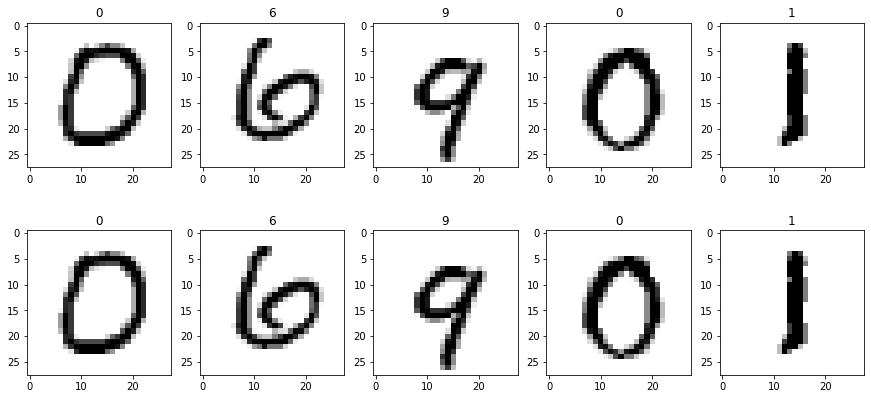

In [44]:
fig = plt.figure(figsize=(15, 7))

for i in range(5):
    plottable_image = x_test[i+10]
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(class_names[y_test[i+10]])
    ax.imshow(plottable_image, cmap='gray_r')
  
for i in range(5):
    plottable_image = x_test[i+10]
    ax = fig.add_subplot(2, 5, i+6)
    ax.title.set_text(class_names[predict[i+10].item()])
    ax.imshow(plottable_image, cmap='gray_r')

plt.show()